# Agent Based Models

An [agent-based model](https://en.wikipedia.org/wiki/Agent-based_model) is a way of modeling some sort of phenomenon using discrete "agents" which interact with other agents, sometimes in very complex ways.  In case this is too abstract, you can think of agents as simulated people, and you're trying to model how they interact with each other.

## Example: Spreading an Idea

Let's say someone has a new idea, and that it is a really good idea.  So good in fact that once someone hears this new idea they can't stop talking about it.  We can model a person, or agent as a Python class with a single attribute:

In [1]:
class Person():
    """
    An agent representing a person.
    
    By default, a person is not enlightened.  They can become enlightened using the englighten method.
    """
    
    def __init__(self):
        self.enlightened = False # if enlightened = True, the person has heard idea

        
    def is_enlightened(self):
        """
        returns true if the person has heard the idea
        """
        return self.enlightened

    
    def enlighten(self):
        """
        once the person
        """
        self.enlightened = True
        
        
a = Person()
print(a.is_enlightened()) # the person is not enlightened by default
a.enlighten() # the person becomes enlightened
print(a.is_enlightened()) # the person is now enlightened

False
True


Now, what we want to do is simulate how this idea spreads through a population.  Say that there are `N` people in the population, and each day each person talks to `k` random other people.  If someone talks to someone else who is enlightened, then the new person becomes enlightened with probability `p`.  We'll start with one enlightened person and keep track of how the idea spreads

In [13]:
N = 1_000 # population size
k = 5     # number of people each person talks to
p = 0.1   # probability that someone is enlightened

pop = [Person() for i in range(N)] # our population
pop[0].enlighten()

now let's write a function that will simulate all interactions in a day

In [11]:
from numpy.random import randint, rand

for i in range(N):
    if pop[i].is_enlightened():
        # person i enlightens all their contacts
        contacts = randint(N, size=k)
        for j in contacts:
            if rand() < p:
                pop[j].enlighten()
        

we want to count how many people are enlightened at the end of the day

In [12]:
def count_enlightened(pop):
    return sum(p.is_enlightened() for p in pop)

count_enlightened(pop)

2

now let's see how the enlightened population changes over time

In [14]:
T = 100 # number of days to simulate
counts = [count_enlightened(pop)]
for t in range(T):
    # update the population
    for i in range(N):
        if pop[i].is_enlightened():
            # person i enlightens all their contacts
            contacts = randint(N, size=k)
            for j in contacts:
                if rand() < p:
                    pop[j].enlighten()
                    
    # add to our counts
    counts.append(count_enlightened(pop))

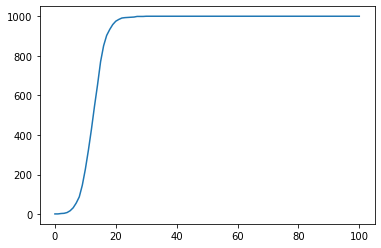

In [15]:
import matplotlib.pyplot as plt

plt.plot(counts)
plt.show()

### Exercises

1. How does changing `N`, `p` and `k` affect the simulation?
2. How would you change the simulation model to say that there is a probablity `q` that an enlightened person will become un-enlightened every day?

In [ ]:
## Your code here


## Phase Diagrams

In our example, there are a couple of parameters we can tweak.  We'll focus on `p` and `k`. One question we might ask is how the outcome changes as we change these parameters.  We'll count the total number of people who are enlightened on day 20.

In [16]:
def run_simulation(p, k, N=1_000, T=20):
    """
    return the number of people enlightened at time T
    """
    
    pop = [Person() for i in range(N)] # our population
    pop[0].enlighten()
    
    for t in range(T):
        # update the population
        for i in range(N):
            if pop[i].is_enlightened():
                # person i enlightens all their contacts
                contacts = randint(N, size=k)
                for j in contacts:
                    if rand() < p:
                        pop[j].enlighten()
                    
    return count_enlightened(pop)

In [21]:
run_simulation(0.1, 5)

950

Now, let's run simulations on a range of values for `k` and `p`

In [22]:
import numpy as np

ks = np.arange(1, 11, dtype=np.int64)
ps = np.logspace(-2,0, 10)

cts = np.zeros((len(ks), len(ps)))
for i, k in enumerate(ks):
    for j, p in enumerate(ps):
        cts[i,j] = run_simulation(p, k)

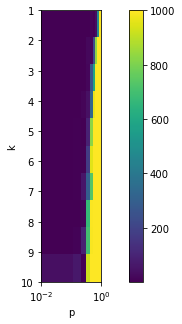

In [23]:
plt.figure(figsize=(10,5))
plt.imshow(cts, extent=[np.min(ps), np.max(ps), np.max(ks), np.min(ks)])
plt.colorbar()
# plt.axis('square')
plt.xscale('log')
plt.xlabel('p')
plt.ylabel('k')

plt.show()

from the above, we see that if `k` and `p` are large enough that the whole population is enlightened on day 20, and if they are too small then very few are enlightened.  There is a phase transition between the blue and yellow regions above, meaning the choice of parameters can cause abrupt changes in the measured behavior of the system

## The Game of Life

You don't necessarily need to use Python objects to encode everything about an agent-based model.  For instance, you might just use an array to store the state of objects in simple simulations, even when behavior is nonlinear.

We'll take a look at [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) implemented using a numpy array.  The game of life takes place on a `m` by `n` grid, and each element of the grid either contains life or it doesn't.  The game models how life might spread over the area of a continent.
The cells are updated at each time step using the following rules:

1. Any live cell with 0 or 1 live neighbors dies (under-population)
2. Any live cell with 2 or 3 neighbors survives until the next time step (sustainable population)
3. Any live cell with more than 3 live neighbors dies (overpopulation)
4. Any dead cell with exactly 3 neighbors becomes alive (reproduction)

Neighbors are either horizontally, vertically, or diagonally adjacent. We'll encode whether a cell is alive or dead using 1 and 0 respectively (or True/False)

In [24]:
m = 100
n = 100

S = np.zeros((m,n), dtype=bool) # grid

In [25]:
def neighbors(i, j, m, n):
    inbrs = [-1, 0, 1]
    if i == 0:
        inbrs = [0, 1]
    if i == m-1:
        inbrs = [-1, 0]
    jnbrs = [-1, 0, 1]
    if j == 0:
        jnbrs = [0, 1]
    if j == n-1:
        jnbrs = [-1, 0]
        
    for delta_i in inbrs:
        for delta_j in jnbrs:
            if delta_i == delta_j == 0:
                continue
            yield i + delta_i, j + delta_j

def count_alive_neighbors(S):
    m, n = S.shape
    cts = np.zeros(S.shape, dtype=np.int64)
    for i in range(m):
        for j in range(n):
            for i2, j2 in neighbors(i, j, m, n):
                cts[i,j] = cts[i,j] + S[i2, j2]
                
    return cts

count_alive_neighbors(S)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

What makes the game of life interesting is that you can get patterns that propagate over your grid

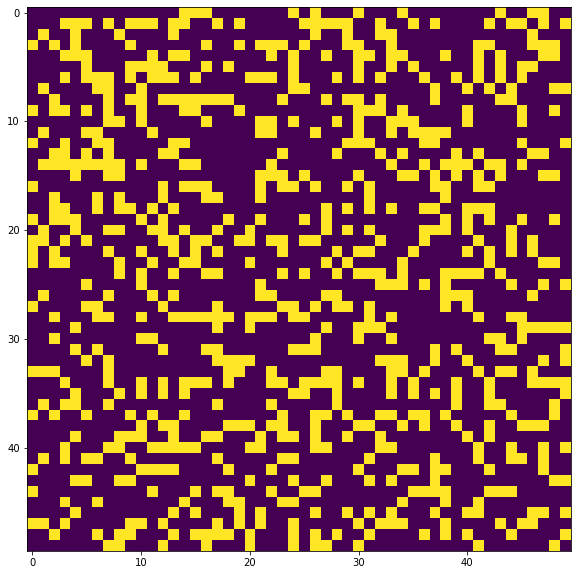

In [26]:
m, n = 50, 50
np.random.seed(0)
S = np.random.rand(m, n) < 0.3
plt.figure(figsize=(10,10))
plt.imshow(S)
plt.show()

The below cell produces an animated GIF of the game of life.  See [here](https://matplotlib.org/2.1.2/gallery/animation/dynamic_image.html) for an example from matplotlib.

''

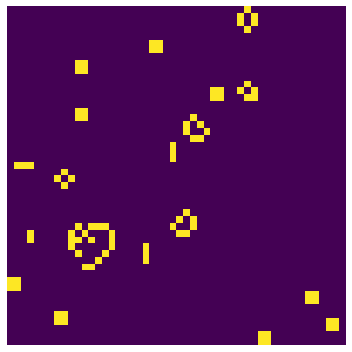

In [27]:
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(5,5))
fig.set_tight_layout(True)

# Plot an image that persists
im = plt.imshow(S, animated=True)
plt.axis('off') # turn off ticks

def update(*args):

    global S
    
    # Update image to display next step
    cts = count_alive_neighbors(S)
    # Game of life update
    S = np.logical_or(
        np.logical_and(cts == 2, S),
        cts == 3
    )
    im.set_array(S)
    return im,

anim = FuncAnimation(fig, update, frames=100, interval=200, blit=True)
anim.save('life.gif', dpi=80, writer='imagemagick')
;

Here's what the GIF looks like:

![](life.gif)